In [1]:
# %% Imports
%matplotlib inline
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
from libs.utils import *
import matplotlib.pyplot as plt

In [2]:
# %% Setup input to the network and true output label.  These are
# simply placeholders which we'll fill in later.
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# %% Since x is currently [batch, height*width], we need to reshape to a
# 4-D tensor to use it in a convolutional graph.  If one component of
# `shape` is the special value -1, the size of that dimension is
# computed so that the total size remains constant.  Since we haven't
# defined the batch dimension's shape yet, we use -1 to denote this
# dimension should not change size.
x_tensor = tf.reshape(x, [-1, 28, 28, 1])

In [4]:
# %% We'll setup the first convolutional layer
# Weight matrix is [height x width x input_channels x output_channels]
filter_size = 5
n_filters_1 = 16
W_conv1 = weight_variable([filter_size, filter_size, 1, n_filters_1])

In [5]:
# %% Bias is [output_channels]
b_conv1 = bias_variable([n_filters_1])

In [6]:
# %% Now we can build a graph which does the first layer of convolution:
# we define our stride as batch x height x width x channels
# instead of pooling, we use strides of 2 and more layers
# with smaller filters.
h_conv1 = tf.nn.relu(
    tf.nn.conv2d(input=x_tensor,
                 filter=W_conv1,
                 strides=[1, 2, 2, 1],
                 padding='SAME') +
    b_conv1)

In [7]:
# %% And just like the first layer, add additional layers to create
# a deep net
n_filters_2 = 16
W_conv2 = weight_variable([filter_size, filter_size, n_filters_1, n_filters_2])
b_conv2 = bias_variable([n_filters_2])
h_conv2 = tf.nn.relu(
    tf.nn.conv2d(input=h_conv1,
                 filter=W_conv2,
                 strides=[1, 2, 2, 1],
                 padding='SAME') +
    b_conv2)

In [8]:
# %% We'll now reshape so we can connect to a fully-connected layer:
h_conv2_flat = tf.reshape(h_conv2, [-1, 7 * 7 * n_filters_2])

In [9]:
# %% Create a fully-connected layer:
n_fc = 1024
W_fc1 = weight_variable([7 * 7 * n_filters_2, n_fc])
b_fc1 = bias_variable([n_fc])
h_fc1 = tf.nn.relu(tf.matmul(h_conv2_flat, W_fc1) + b_fc1)

In [10]:
# %% We can add dropout for regularizing and to reduce overfitting like so:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [11]:
# %% And finally our softmax layer:
W_fc2 = weight_variable([n_fc, 10])
b_fc2 = bias_variable([10])
y_pred = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [12]:
# %% Define loss/eval/training functions
cross_entropy = -tf.reduce_sum(y * tf.log(y_pred))
optimizer = tf.train.AdamOptimizer().minimize(cross_entropy)

In [13]:
# %% Monitor accuracy
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [15]:
# %% We now create a new session to actually perform the initialization the
# variables:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
# %% We'll train in minibatches and report accuracy:
batch_size = 100
n_epochs = 5
for epoch_i in range(n_epochs):
    for batch_i in range(mnist.train.num_examples // batch_size):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        sess.run(optimizer, feed_dict={
            x: batch_xs, y: batch_ys, keep_prob: 0.5})
    print(sess.run(accuracy,
                   feed_dict={
                       x: mnist.validation.images,
                       y: mnist.validation.labels,
                       keep_prob: 1.0
                   }))

0.9692
0.9796
0.9846
0.9862
0.9864


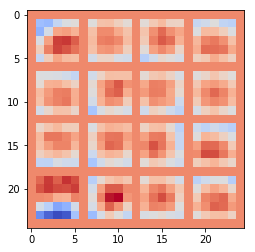

In [17]:
# %% Let's take a look at the kernels we've learned
W = sess.run(W_conv1)
plt.imshow(montage(W / np.max(W)), cmap='coolwarm')